# Manual enumeration of Variable in the Guide

### TASK
Given the data you need to infer:
1. two locations
2. two scales
3. assigment for each data point

### MODEL
with pyro.plate('components', 2):

    loc ~ dist.Normal(0., 5.)
    
    scale ~ dist.LogNormal(0., 0.1)
    
with pyro.plate('data', batch_size):

    p ~ dist.Beta(concentration0=2, concentration1=2)
    
    c ~ dist.Bernoulli(p)
    
    x ~ dist.Normal(loc[c],scale[c])
    
### GUIDE
alpha = pyro.param('alpha', dist.LogNormal(0., 0.5).expand([2]))

beta = pyro.param('beta', dist.LogNormal(0., 0.5).expand([2]))

with pyro.plate('data', batch_size):

    p ~ dist.Beta(concentration0=alpha, concentration1=beta)
    
    c ~ dist.Bernoulli(p)
    
### Comparison
I will compare:
1. Trace_ELBO
2. TraceGraph_ELBO
3. TraceEnum_ELBO in model
4. TraceEnum_ELBO in guide
5. Manual Enumeration in guide

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
import pyro
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO
from pyro.optim import Adam

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Set up pyro environment\n",
smoke_test= False
if(smoke_test):
   pyro.enable_validation(True)
   pyro.distributions.enable_validation(True)
   NUM_EPOCHS = 6
else:
   pyro.enable_validation(False)
   pyro.distributions.enable_validation(False)
   NUM_EPOCHS = 101

assert(pyro.__version__.startswith('0.4'))
assert(torch.__version__.startswith('1.2'))

In [3]:
def normal(x, mu, sigma):
    """ Return the value of N(mu,sigma) at the locations x

        Typical usage:
        x = np.arange(0.0,1.0,0.01)
        y1 = normal(x,0.1,0.1)
        plt.plot(x,y1,'-')
    """
    tmp = ((x-mu)/sigma)**2
    c = 1.0/(np.sqrt(2*np.pi)*sigma)
    return np.exp(-0.5*tmp)*c

## Define Model and Guide

In [17]:
#Fix the number of components
K = 2
def model(data=None, N=100, verbose=False):
    if(data is None):
        batch_size = N
        observed=False
    else:
        batch_size = data.shape[0]
        observed=True
    one = torch.ones([1])
        
    # Global variables.
    with pyro.plate('components', K):
        loc = pyro.sample('loc', dist.Normal(0*one, 5*one))
        
    with pyro.plate('data', batch_size):
        p = pyro.sample('p', dist.Beta(concentration0=0.5*one, concentration1=0.2*one))
        c = pyro.sample('c', dist.Bernoulli(p)).long()
        
        if(observed):
            x = pyro.sample('obs', dist.Normal(loc[c], one), obs=data)
        else:
            x = dist.Normal(loc[c], one).sample()
    
    return {'loc':loc, 'p':p, 'c':c, 'x':x}      

def guide(data=None, N=100):
    if(data is None):
        batch_size = N
    else:
        batch_size = data.shape[0]
        
    ones = torch.ones([K])  
    loc_mu = pyro.param('loc_mu', torch.randn(K), constraint=constraints.real)
    
    with pyro.plate('components', K):
        #loc = pyro.sample('loc', dist.Normal(locs_mu, locs_std))
        #scale = pyro.sample('scale', dist.LogNormal(scale_mu, scale_std)) 
        loc = pyro.sample('loc', dist.Delta(loc_mu))
        
    alpha = pyro.param('alpha', dist.LogNormal(0., 0.5).expand([batch_size]))
    beta = pyro.param('beta', dist.LogNormal(0., 0.5).expand([batch_size]))
    with pyro.plate('data', batch_size):
        p = pyro.sample("p", dist.Beta(concentration0=alpha, concentration1=beta))
        c = pyro.sample("c", dist.Bernoulli(p), infer={"enumerate": "parallel"})    
    

# Generate and Visualize the input data

In [18]:
truth = model(data=None, N=10000)

loc tensor([-1.0174,  5.9436])


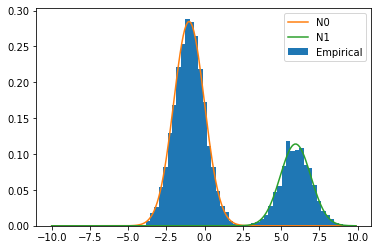

In [19]:
x = np.arange(-10,10,0.1)
y0 = normal(x, truth["loc"][0].numpy(), 1.0)
y1 = normal(x, truth["loc"][1].numpy(), 1.0)
n1 = torch.sum(truth["c"]).float()
n0 = torch.sum(1-truth["c"]).float()
f0 = (n0/(n0+n1)).numpy()
f1 = (n1/(n0+n1)).numpy()

plt.hist(truth["x"].numpy(), bins=50, density=True, label="Empirical")
plt.plot(x, y0*f0, '-', label="N0")
plt.plot(x, y1*f1, '-', label="N1")
plt.legend()

print("loc",truth["loc"])

# TraceEnum_ELBO

In [20]:
# Initialization
optim = Adam({'lr': 2E-3})
EPOCH_MAX = 20000
pyro.clear_param_store()
svi = SVI(model, guide, optim, loss=TraceEnum_ELBO(max_plate_nesting=1))

ENUM_history = { "loss":[], "l0":[], "l1":[], "s0":[], "s1":[]}
ENUM_final = {"pa":[], "pb":[]}

In [22]:
# Training
for i in range(EPOCH_MAX):
    loss = svi.step(truth['x'])
    loc = pyro.param("loc_mu").detach().numpy()
    ENUM_history["loss"].append(loss)
    ENUM_history["l0"].append(loc[0])
    ENUM_history["l1"].append(loc[1])
    if (i%1000)==0:
        print(i,loss,loc)
ENUM_final["pa"] = pyro.param("alpha").detach().numpy()
ENUM_final["pb"] = pyro.param("beta").detach().numpy()

0 84191.484375 [-1.3462149   0.50211585]
1000 44895.8359375 [-0.71743083  2.8229885 ]
2000 36738.91015625 [-0.80757517  4.2608943 ]
3000 34291.05078125 [-0.82656693  5.0305576 ]
4000 33440.16796875 [-0.83674604  5.3173046 ]
5000 32322.228515625 [-0.84897655  5.4062195 ]
6000 32228.279296875 [-0.8566862  5.4567447]
7000 31621.998046875 [-0.86218196  5.493587  ]
8000 31412.0234375 [-0.8699378  5.525022 ]
9000 31174.22265625 [-0.8748192  5.54898  ]
10000 30815.818359375 [-0.87805426  5.5742826 ]
11000 30525.1015625 [-0.8809972  5.5963554]


KeyboardInterrupt: 

### Plot Results

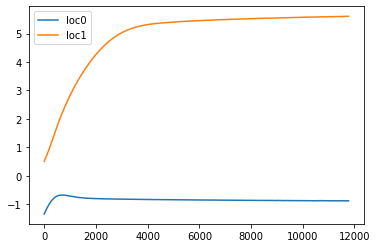

In [23]:
plt.plot(ENUM_history["l0"], label = "loc0")
plt.plot(ENUM_history["l1"], label = "loc1")
plt.legend()

In [25]:

ENUM_final["pa"] = pyro.param("alpha").detach().numpy()
ENUM_final["pb"] = pyro.param("beta").detach().numpy()

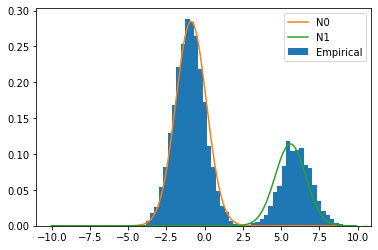

In [27]:
x = np.arange(-10,10,0.1)
p_mean = ENUM_final["pa"]/(ENUM_final["pa"]+ENUM_final["pb"])
n0=np.sum(p_mean>0.5)
n1=np.sum(p_mean<0.5)
f0=float(n0)/(n0+n1)
f1=float(n1)/(n0+n1)
y0 = normal(x, ENUM_history["l0"][-1], 1.0)
y1 = normal(x, ENUM_history["l1"][-1], 1.0)
plt.hist(truth["x"].numpy(), bins=50, density=True, label="Empirical")
plt.plot(x, y0*f0, '-', label="N0")
plt.plot(x, y1*f1, '-', label="N1")
plt.legend()

In [28]:
# Initialization
optim = Adam({'lr': 2E-3})
EPOCH_MAX = 20000
pyro.clear_param_store()
svi = SVI(model, guide, optim, loss=TraceGraph_ELBO(max_plate_nesting=1))

GRAPH_history = { "loss":[], "l0":[], "l1":[], "s0":[], "s1":[]}
GRAPH_final = {"pa":[], "pb":[]}

In [29]:
# Training
for i in range(EPOCH_MAX):
    loss = svi.step(truth['x'])
    loc = pyro.param("loc_mu").detach().numpy()
    GRAPH_history["loss"].append(loss)
    GRAPH_history["l0"].append(loc[0])
    GRAPH_history["l1"].append(loc[1])
    if (i%1000)==0:
        print(i,loss,loc)
GRAPH_final["pa"] = pyro.param("alpha").detach().numpy()
GRAPH_final["pb"] = pyro.param("beta").detach().numpy()

0 82140.171875 [-0.6237607  -0.51964223]
1000 64505.3984375 [0.4154641 1.1543058]
2000 52947.51953125 [-0.04940033  2.7517436 ]
3000 40827.9453125 [-0.6690883  4.2683015]
4000 36796.26171875 [-0.7580003  4.945924 ]
5000 36691.55859375 [-0.7784154  5.1335955]


/Users/ldalessi/anaconda3/envs/pyro/lib/python3.7/site-packages/pyro/infer/tracegraph_elbo.py:258: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


6000 nan [-0.79388815  5.2100863 ]
7000 nan [-0.8024302  5.264534 ]
8000 nan [-0.81653845  5.312209  ]
9000 nan [-0.81783813  5.3451543 ]
10000 nan [-0.8278863  5.3683577]
11000 nan [-0.8295423  5.392592 ]
12000 nan [-0.84020865  5.4031143 ]
13000 nan [-0.8388555  5.4263515]
14000 nan [-0.8529871  5.452964 ]
15000 nan [-0.8455192  5.4726896]
16000 nan [-0.85392994  5.4801545 ]
17000 nan [-0.8506488  5.502721 ]
18000 nan [-0.85661614  5.5276847 ]
19000 nan [-0.8652554  5.5253763]
